<a href="https://colab.research.google.com/github/Mar-vm/VitalIA/blob/mariana/entrenamiento_2modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 📂 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# ⚙️ Configuración general
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

base_dir = "/content/drive/MyDrive/skin_cancer_data2"
save_path_efficient = "/content/drive/MyDrive/modelo_efficientnet_skin_cancer.pth"
save_path_mobilenet = "/content/drive/MyDrive/modelo_mobilenet_skin_cancer.pth"


In [ ]:

# 🔄 Transformaciones y dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(base_dir, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = dataset.classes
print(f"📚 Clases: {class_names}")


📚 Clases: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:

# 🚂 Función de entrenamiento
def entrenar_modelo(model, save_path, nombre_modelo):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    history = []
    best_acc = 0.0

    for epoch in range(5):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"{nombre_modelo} - Época {epoch+1}/5"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        scheduler.step()

        print(f"{nombre_modelo} -> Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        history.append({
            'epoch': epoch+1,
            'train_acc': train_acc,
            'val_acc': val_acc
        })

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ {nombre_modelo} mejorado y guardado.")

    return pd.DataFrame(history)


In [ ]:

# 🧠 EfficientNet
model_efficient = models.efficientnet_b0(pretrained=True)
model_efficient.classifier[1] = nn.Linear(model_efficient.classifier[1].in_features, len(class_names))

hist_efficient = entrenar_modelo(model_efficient, save_path_efficient, "EfficientNetB0")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]
EfficientNetB0 - Época 1/5: 100%|██████████| 249/249 [35:50<00:00,  8.64s/it]


EfficientNetB0 -> Loss: 0.7073, Train Acc: 75.17%, Val Acc: 81.45%
✅ EfficientNetB0 mejorado y guardado.


EfficientNetB0 - Época 2/5: 100%|██████████| 249/249 [37:42<00:00,  9.09s/it]


EfficientNetB0 -> Loss: 0.4984, Train Acc: 81.98%, Val Acc: 82.81%
✅ EfficientNetB0 mejorado y guardado.


EfficientNetB0 - Época 3/5: 100%|██████████| 249/249 [37:32<00:00,  9.05s/it]


EfficientNetB0 -> Loss: 0.3910, Train Acc: 85.88%, Val Acc: 84.31%
✅ EfficientNetB0 mejorado y guardado.


EfficientNetB0 - Época 4/5: 100%|██████████| 249/249 [37:46<00:00,  9.10s/it]


EfficientNetB0 -> Loss: 0.1895, Train Acc: 93.39%, Val Acc: 88.34%
✅ EfficientNetB0 mejorado y guardado.


EfficientNetB0 - Época 5/5: 100%|██████████| 249/249 [38:07<00:00,  9.19s/it]


EfficientNetB0 -> Loss: 0.1211, Train Acc: 95.86%, Val Acc: 88.29%


In [ ]:

# 🧠 MobileNet
model_mobile = models.mobilenet_v2(pretrained=True)
model_mobile.classifier[1] = nn.Linear(model_mobile.classifier[1].in_features, len(class_names))

hist_mobile = entrenar_modelo(model_mobile, save_path_mobilenet, "MobileNetV2")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 51.8MB/s]
MobileNetV2 - Época 1/5: 100%|██████████| 249/249 [27:46<00:00,  6.69s/it]


MobileNetV2 -> Loss: 0.7556, Train Acc: 72.74%, Val Acc: 77.78%
✅ MobileNetV2 mejorado y guardado.


MobileNetV2 - Época 2/5: 100%|██████████| 249/249 [27:44<00:00,  6.69s/it]


MobileNetV2 -> Loss: 0.6205, Train Acc: 77.35%, Val Acc: 79.24%
✅ MobileNetV2 mejorado y guardado.


MobileNetV2 - Época 3/5: 100%|██████████| 249/249 [27:44<00:00,  6.69s/it]


MobileNetV2 -> Loss: 0.5356, Train Acc: 80.50%, Val Acc: 80.09%
✅ MobileNetV2 mejorado y guardado.


MobileNetV2 - Época 4/5: 100%|██████████| 249/249 [28:18<00:00,  6.82s/it]


MobileNetV2 -> Loss: 0.3699, Train Acc: 86.37%, Val Acc: 85.22%
✅ MobileNetV2 mejorado y guardado.


MobileNetV2 - Época 5/5: 100%|██████████| 249/249 [28:00<00:00,  6.75s/it]


MobileNetV2 -> Loss: 0.2829, Train Acc: 89.78%, Val Acc: 85.22%


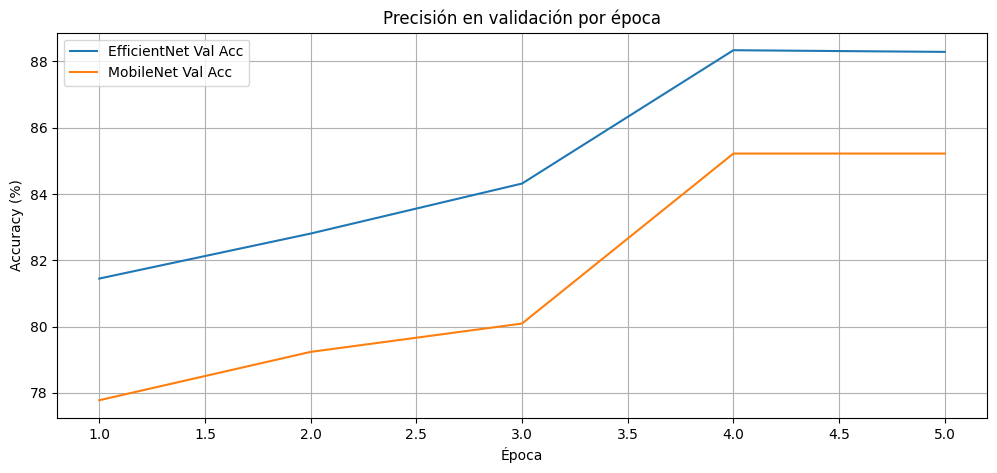

In [ ]:

# 📊 Comparación de desempeño
plt.figure(figsize=(12, 5))
plt.plot(hist_efficient['epoch'], hist_efficient['val_acc'], label='EfficientNet Val Acc')
plt.plot(hist_mobile['epoch'], hist_mobile['val_acc'], label='MobileNet Val Acc')
plt.title('Precisión en validación por época')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model_mobile.state_dict(), "/content/drive/MyDrive/modelo_mobilenet_skin_cancer.pth")


In [ ]:
# Verifica si el archivo está presente
!ls -lh /content/drive/MyDrive/modelo_mobilenet_skin_cancer.pth


-rw------- 1 root root 8.8M Apr  7 03:33 /content/drive/MyDrive/modelo_mobilenet_skin_cancer.pth


In [ ]:
# 💾 Guardar modelo EfficientNet entrenado en Google Drive
torch.save(model_efficient.state_dict(), "/content/drive/MyDrive/modelo_efficientnet_skin_cancer.pth")



In [ ]:
!ls -lh /content/drive/MyDrive/*.pth


-rw------- 1 root root  16M Apr  7 03:34 /content/drive/MyDrive/modelo_efficientnet_skin_cancer.pth
-rw------- 1 root root 8.8M Apr  7 03:33 /content/drive/MyDrive/modelo_mobilenet_skin_cancer.pth


In [ ]:
# ✅ Obtener clases desde el dataset
class_names = dataset.classes
print("Clases:", class_names)


Clases: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# 💾 Guardar clases como archivo JSON en Drive
import json

clases_path = "/content/drive/MyDrive/skin_cancer_clases.json"
with open(clases_path, "w") as f:
    json.dump(class_names, f)

print("✅ Clases guardadas en:", clases_path)


✅ Clases guardadas en: /content/drive/MyDrive/skin_cancer_clases.json


In [ ]:
# Verifica si el archivo está presente
!ls -lh /content/drive/MyDrive/skin_cancer_clases.json

-rw------- 1 root root 50 Apr  7 03:39 /content/drive/MyDrive/skin_cancer_clases.json
